# Agrégation des modèles et switch avec le trafic aérien

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Importe les deux modèles

In [2]:
#importation modèle sarima
nb_touristes_sarima = pd.read_csv("nb_touristes_sarima.csv", index_col=0)
nb_touristes_sarima["date"] = pd.to_datetime(nb_touristes_sarima["date"])
nb_touristes_sarima

,date,France métropolitaine,Bretagne,Hauts-de-France,Bourgogne-Franche-Comté,Grand Est,Corse,Centre-Val de Loire,Occitanie,Pays de la Loire,Normandie,Nouvelle-Aquitaine,Île-de-France,Provence-Alpes-Côte d'Azur,Auvergne-Rhône-Alpes
0,2018-01-01,7167.409847,240.366053,348.504215,279.334014,495.596662,24.318664,204.755434,485.161548,245.299882,241.147464,489.795921,2556.671409,582.425875,974.032705
1,2018-01-02,7187.233205,241.434996,349.446339,281.289591,497.774001,24.596712,205.316895,487.449736,245.863217,242.418729,492.652638,2554.972344,584.592912,979.425094
2,2018-01-03,7207.056563,242.503939,350.388463,283.245167,499.951339,24.874760,205.878357,489.737924,246.426552,243.689995,495.509355,2553.273280,586.759950,984.817483
3,2018-01-04,7226.879920,243.572882,351.330587,285.200744,502.128677,25.152807,206.439818,492.026113,246.989887,244.961260,498.366072,2551.574215,588.926987,990.209871
4,2018-01-05,7246.703278,244.641826,352.272710,287.156321,504.306016,25.430855,207.001279,494.314301,247.553222,246.232526,501.222788,2549.875150,591.094025,995.602260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,2021-09-27,7358.177375,311.769260,241.560235,417.163794,361.815087,122.396430,274.950195,1182.666867,333.351851,241.403661,686.428402,1739.329462,743.770997,701.571135
1366,2021-09-28,7334.657384,308.402874,241.087002,414.165170,361.920596,119.285460,274.115629,1180.945597,329.321902,239.452977,682.850979,1748.011122,740.384531,694.713546
1367,2021-09-29,7311.137393,305.036488,240.613770,411.166546,362.026105,116.174489,273.281062,1179.224327,325.291953,237.502292,679.273557,1756.692783,736.998064,687.855957
1368,2021-09-30,7287.617401,301.670102,240.140538,408.167921,362.131614,113.063518,272.446496,1177.503058,321.262004,235.551607,675.696135,1765.374444,733.611597,680.998368


In [3]:
nb_touristes_sarima2 = nb_touristes_sarima.set_index("date")

In [4]:
#importation modèle ggt
nb_touristes_ggt = pd.read_csv("nb_touristes_ggt.csv", index_col=0)
nb_touristes_ggt["date"] = pd.to_datetime(nb_touristes_ggt["date"])
nb_touristes_ggt

,date,France métropolitaine,Bretagne,Hauts-de-France,Bourgogne-Franche-Comté,Grand Est,Corse,Centre-Val de Loire,Occitanie,Pays de la Loire,Normandie,Nouvelle-Aquitaine,Île-de-France,Provence-Alpes-Côte d'Azur,Auvergne-Rhône-Alpes
0,2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4378,2021-12-27,5469.477789,255.495895,319.991277,371.420810,452.965806,0.307980,294.416866,372.179420,85.477269,265.793208,290.805297,1436.592584,527.502182,796.529194
4379,2021-12-28,5540.888548,251.387101,319.210790,362.348600,439.221576,1.133021,300.106808,378.367588,93.083824,276.890003,297.998847,1472.073559,534.204811,814.862019
4380,2021-12-29,5575.657088,253.671402,318.186475,351.209030,434.889327,1.303192,299.979293,377.837244,86.442347,282.540358,304.416401,1495.891173,536.710346,832.580499
4381,2021-12-30,5652.197835,261.354856,312.575941,355.299902,434.161736,1.303192,297.803291,372.183060,86.553242,290.878115,314.703783,1533.822465,550.963661,840.594589


In [5]:
nb_touristes_ggt2 = nb_touristes_ggt.set_index("date")

### Importe données officielles pour comparer avec le modèle

In [6]:
#Importe données groupées par mois
df_France_Official_Data2 = pd.read_csv("df_France_Official_Data_month.csv", index_col=0)
df_France_Official_Data2['date'] = pd.to_datetime(df_France_Official_Data2['date'])

In [7]:
#Base avec les régions :
base_regions_dep = pd.read_csv('departements-region.csv')
base_regions_dep.rename(columns={'dep_name': 'department'}, inplace=True)

In [8]:
#On merge pour rajouter la colonne région
df_France_Official_Data3 = df_France_Official_Data2.merge(base_regions_dep, on='department', how='left')
df_France_Official_Data3.head(3)

,date,department,value_in_thousands,num_dep,region_name
0,2011-01-01,Ain,47.32,01,Auvergne-Rhône-Alpes
1,2011-01-01,Aisne,21.78,02,Hauts-de-France
2,2011-01-01,Allier,23.62,03,Auvergne-Rhône-Alpes


### Trafic aérien pour switcher de modèle

In [9]:
#importe les données transformées du trafic aérien
df_air_trafic = pd.read_csv("df_air_trafic_corrigee.csv", index_col=0)
df_air_trafic['sheduled_time_start'] = pd.to_datetime(df_air_trafic['sheduled_time_start'])
df_air_trafic

,country_origin,citydest,sheduled_time_start,seats,number_planes,Year,Month,Day,Year-Month
64488,Hungary,Paris,2017-05-16,462.0,3,2017,5,16,2017-05
64345,Germany,Basel,2017-05-16,592.0,5,2017,5,16,2017-05
64346,France,Toulon,2017-05-16,334.0,3,2017,5,16,2017-05
64347,France,Bordeaux,2017-05-16,1736.0,15,2017,5,16,2017-05
64348,Portugal,Toulouse,2017-05-16,437.0,3,2017,5,16,2017-05
...,...,...,...,...,...,...,...,...,...
265668,Germany,Paris,2021-12-07,1314.0,9,2021,12,7,2021-12
265666,Portugal,Paris,2021-12-07,183.0,2,2021,12,7,2021-12
265684,France,Nice,2021-12-07,1387.0,9,2021,12,7,2021-12
265672,Tunisia,Paris,2021-12-07,298.0,2,2021,12,7,2021-12


In [10]:
#on supprime les colonnes inutiles
df_air_trafic2 = df_air_trafic.drop(['number_planes', "Year", "Month", "Day", "Year-Month", "country_origin", "citydest"], axis=1)

In [11]:
#regroupe par jour
df_air_trafic2 = df_air_trafic2.groupby('sheduled_time_start').agg({'seats': "sum"})
df_air_trafic2

,seats
sheduled_time_start,
2017-05-16,137671.0
2017-05-17,158894.0
2017-05-18,163676.0
2017-05-19,129127.0
2017-05-20,151465.0
...,...
2021-12-03,77261.0
2021-12-04,62891.0
2021-12-05,78047.0


### Recherche des valeurs seuils

In [12]:
df_air_trafic2["seats_rolling"] = df_air_trafic2["seats"].rolling(window = 7).mean()
df_air_trafic2["variation_sieges_pourcentage"] = df_air_trafic2["seats_rolling"].pct_change(periods=7)
df_air_trafic2

,seats,seats_rolling,variation_sieges_pourcentage
sheduled_time_start,,,
2017-05-16,137671.0,NaN,NaN
2017-05-17,158894.0,NaN,NaN
2017-05-18,163676.0,NaN,NaN
2017-05-19,129127.0,NaN,NaN
2017-05-20,151465.0,NaN,NaN
...,...,...,...
2021-12-03,77261.0,67888.571429,-0.036331
2021-12-04,62891.0,67934.285714,-0.032659
2021-12-05,78047.0,67330.000000,-0.037518


<AxesSubplot:xlabel='sheduled_time_start'>

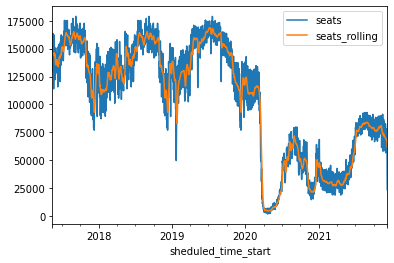

In [13]:
df_air_trafic2[["seats","seats_rolling"]].plot()

In [14]:
#on remet la colonne avec la date
df_air_trafic3 = df_air_trafic2.reset_index()

In [15]:
#minimum sièges sur la période pré-covid
df_air_trafic3["seats_rolling"][df_air_trafic3["sheduled_time_start"]<"2020-03-01"].describe()

count      1014.000000
mean     139131.006481
std       19625.039417
min       82641.000000
25%      123545.535714
50%      140602.000000
75%      158373.714286
max      168745.714286
Name: seats_rolling, dtype: float64

In [16]:
df_air_trafic2["seats_rolling"].describe(percentiles=[ 0,0.1 ,0.2, 0.3, 0.4, 0.50, 0.6, 0.7, 0.8, 0.9, 1])

count      1661.000000
mean     103238.086007
std       50219.947471
min        4408.571429
0%         4408.571429
10%       28322.428571
20%       44989.142857
30%       74742.000000
40%      103943.285714
50%      117733.714286
60%      129135.428571
70%      141823.428571
80%      154661.571429
90%      160527.714286
100%     168745.714286
max      168745.714286
Name: seats_rolling, dtype: float64

<AxesSubplot:xlabel='sheduled_time_start'>

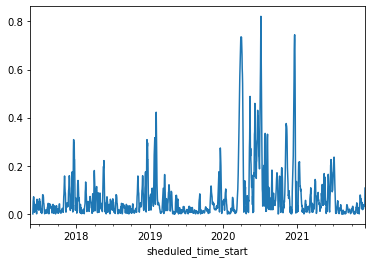

In [17]:
df_air_trafic2["variation_sieges_pourcentage"].abs().plot()

In [18]:
#variation sur la période pré-covid
df_air_trafic3["variation_sieges_pourcentage"][df_air_trafic3["sheduled_time_start"]<"2020-03-01"].abs().describe()
#la variation max c'est pour le jour avec un bug de collecte

count    1007.000000
mean        0.046854
std         0.056135
min         0.000039
25%         0.012769
50%         0.027491
75%         0.060302
max         0.422846
Name: variation_sieges_pourcentage, dtype: float64

In [19]:
#variation sur la période covid
df_air_trafic3["variation_sieges_pourcentage"][df_air_trafic3["sheduled_time_start"]>="2020-03-01"].abs().describe()

count    647.000000
mean       0.115924
std        0.154238
min        0.000012
25%        0.019916
50%        0.054457
75%        0.147873
max        0.821286
Name: variation_sieges_pourcentage, dtype: float64

### Agrégation des modèles

In [20]:
prevision_touristes = pd.DataFrame(columns=['date', 'France métropolitaine', 'Bretagne', 'Hauts-de-France', 'Bourgogne-Franche-Comté', 
                                            'Grand Est', 'Corse', 'Centre-Val de Loire', 'Occitanie', 'Pays de la Loire', 'Normandie', 
                                            'Nouvelle-Aquitaine', 'Île-de-France', "Provence-Alpes-Côte d'Azur", "Auvergne-Rhône-Alpes"])
    
prevision_touristes['date'] = pd.DataFrame(pd.date_range("2018-01-01", "2021-10-01"))
prevision_touristes.set_index('date', drop=False, inplace=True)

for date in prevision_touristes['date']:
    
    for region in prevision_touristes.columns.drop('date'):
        
        #si le nb de sièges est élevé (> au minimum obtenu sur la période pré-covid : 82641 arrondi à 82000) 
        #et que la variation du nb de sièges est faible (< à la variation maximale obtenue sur la période pré-covid : 0.422846 arrondie à 0,43)
        #alors : on est en période stable : on prend modèle sarima temps réel

        if ( (float(df_air_trafic3["seats_rolling"][df_air_trafic3["sheduled_time_start"]==date]) >= 82000) & (float(df_air_trafic3["variation_sieges_pourcentage"][df_air_trafic3["sheduled_time_start"]==date]) <= 0.43) ) :
            prevision_touristes.loc[date, region] = nb_touristes_sarima2.loc[date, region]

        else : 
            prevision_touristes.loc[date, region] = nb_touristes_ggt2.loc[date, region]

                                                                 
prevision_touristes
                                                                 
                                                                 
#mix des deux modèles pas utilisé
#prevision_touristes.loc[date, region] = 0.5*nb_touristes_sarima2.loc[date, region] + 0.5*nb_touristes_ggt2.loc[date, region]


,date,France métropolitaine,Bretagne,Hauts-de-France,Bourgogne-Franche-Comté,Grand Est,Corse,Centre-Val de Loire,Occitanie,Pays de la Loire,Normandie,Nouvelle-Aquitaine,Île-de-France,Provence-Alpes-Côte d'Azur,Auvergne-Rhône-Alpes
date,,,,,,,,,,,,,,,
2018-01-01,2018-01-01,7167.409847,240.366053,348.504215,279.334014,495.596662,24.318664,204.755434,485.161548,245.299882,241.147464,489.795921,2556.671409,582.425875,974.032705
2018-01-02,2018-01-02,7187.233205,241.434996,349.446339,281.289591,497.774001,24.596712,205.316895,487.449736,245.863217,242.418729,492.652638,2554.972344,584.592912,979.425094
2018-01-03,2018-01-03,7207.056563,242.503939,350.388463,283.245167,499.951339,24.87476,205.878357,489.737924,246.426552,243.689995,495.509355,2553.27328,586.75995,984.817483
2018-01-04,2018-01-04,7226.87992,243.572882,351.330587,285.200744,502.128677,25.152807,206.439818,492.026113,246.989887,244.96126,498.366072,2551.574215,588.926987,990.209871
2018-01-05,2018-01-05,7246.703278,244.641826,352.27271,287.156321,504.306016,25.430855,207.001279,494.314301,247.553222,246.232526,501.222788,2549.87515,591.094025,995.60226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-27,2021-09-27,7907.763656,342.710625,438.630067,597.636648,483.565499,33.119165,429.50116,564.533269,310.46225,244.702657,797.363117,1931.87835,642.669181,1090.991667
2021-09-28,2021-09-28,7911.707515,336.299926,438.464138,590.808358,505.871204,32.130616,417.03084,562.099619,303.129607,239.833362,791.028467,1953.355518,658.330567,1083.325293
2021-09-29,2021-09-29,7826.135319,335.165207,445.897735,580.28241,486.428037,31.077138,410.299184,532.890324,302.307825,237.152567,788.695746,1953.008781,643.784944,1079.145421


### Le modèle de nowcasting du tourisme en France

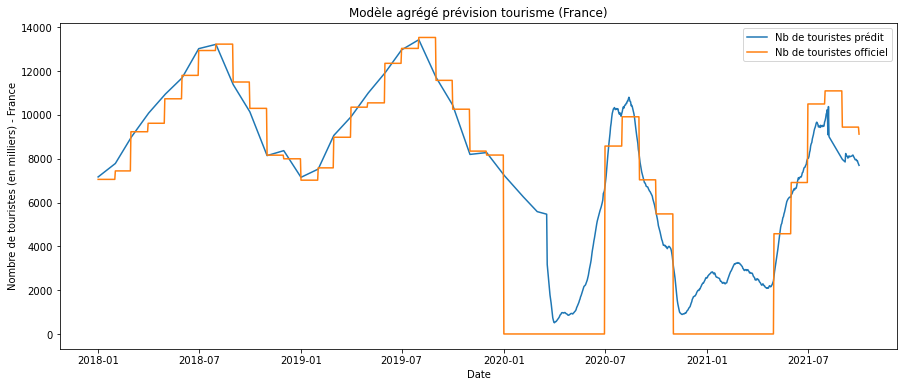

In [21]:
x = prevision_touristes["date"]

y1 = prevision_touristes["France métropolitaine"]

nb_touristes_off = df_France_Official_Data2.groupby('date').sum().reset_index()
df_days = pd.DataFrame(pd.date_range("2018-01-01", "2021-10-01")).rename(columns={0:"date"})
nb_touristes_off_jour = df_days.merge(nb_touristes_off, how="left").set_index('date')
nb_touristes_off_jour['value_in_thousands'] = nb_touristes_off_jour['value_in_thousands'].ffill()
y2 = nb_touristes_off_jour['value_in_thousands']

plt.figure(1, figsize=(15, 6))
plt.plot(x, y1, label="Nb de touristes prédit")
plt.plot(x, y2, label="Nb de touristes officiel")
plt.title('Modèle agrégé prévision tourisme (France)')
plt.xlabel('Date')
plt.ylabel("Nombre de touristes (en milliers) - France")
plt.legend()

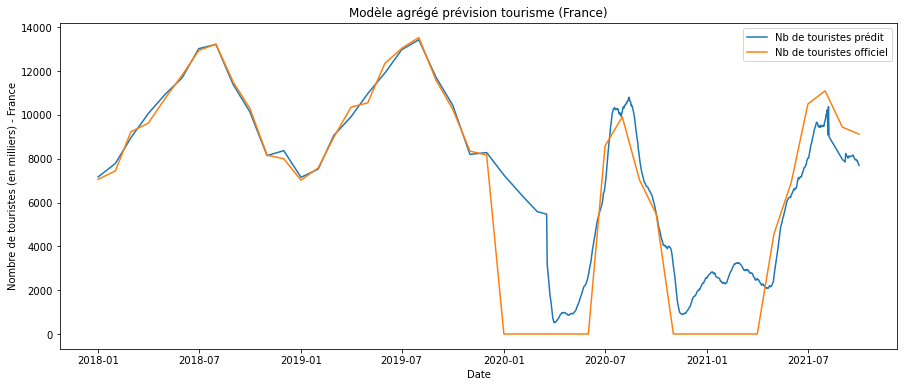

In [22]:
x = prevision_touristes["date"]

y1 = prevision_touristes["France métropolitaine"]

nb_touristes_off = df_France_Official_Data2.groupby('date').sum().reset_index()
df_days = pd.DataFrame(pd.date_range("2018-01-01", "2021-10-01")).rename(columns={0:"date"})
nb_touristes_off_jour = df_days.merge(nb_touristes_off, how="left").set_index('date')
nb_touristes_off_jour['value_in_thousands'] = nb_touristes_off_jour['value_in_thousands'].interpolate(method='linear')
y2 = nb_touristes_off_jour['value_in_thousands']

plt.figure(1, figsize=(15, 6))
plt.plot(x, y1, label="Nb de touristes prédit")
plt.plot(x, y2, label="Nb de touristes officiel")
plt.title('Modèle agrégé prévision tourisme (France)')
plt.xlabel('Date')
plt.ylabel("Nombre de touristes (en milliers) - France")
plt.legend()

### Le modèle de nowcasting du tourisme par région

In [23]:
#Fonction qui réduit la base des données officielles à 1 seule région :

def reduc_base_region(region):
        
    #Données région
    df_Official_Data_region = df_France_Official_Data3[df_France_Official_Data3['region_name']==region]
    
    #On regroupe par mois
    df_Official_Data_region2 = df_Official_Data_region.groupby('date').sum() 

    return(df_Official_Data_region2)

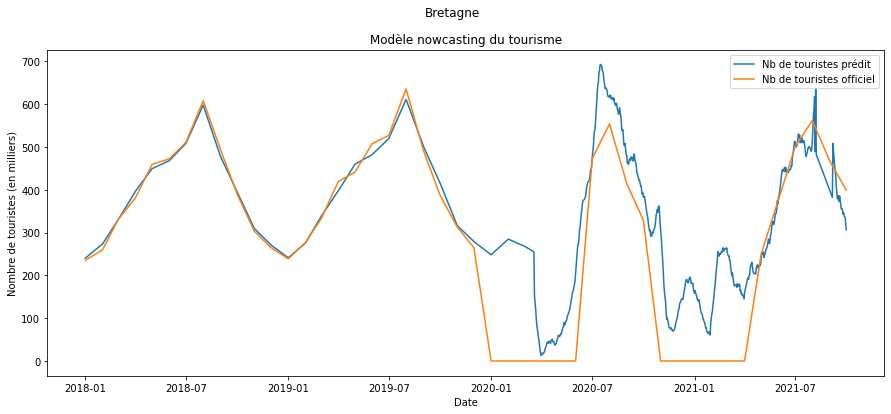

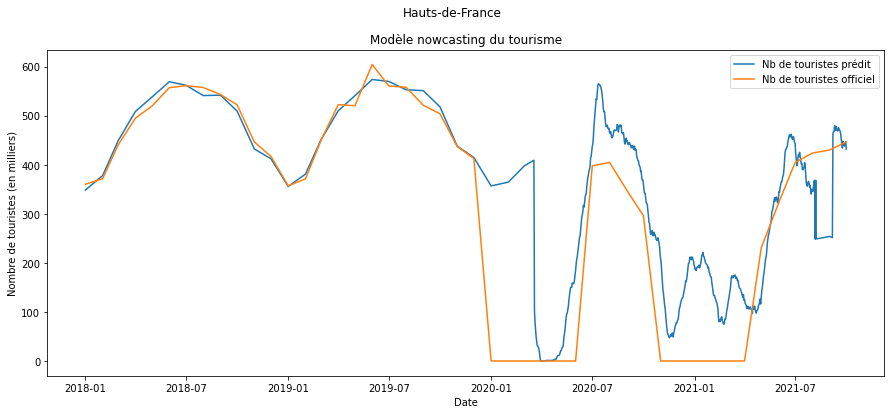

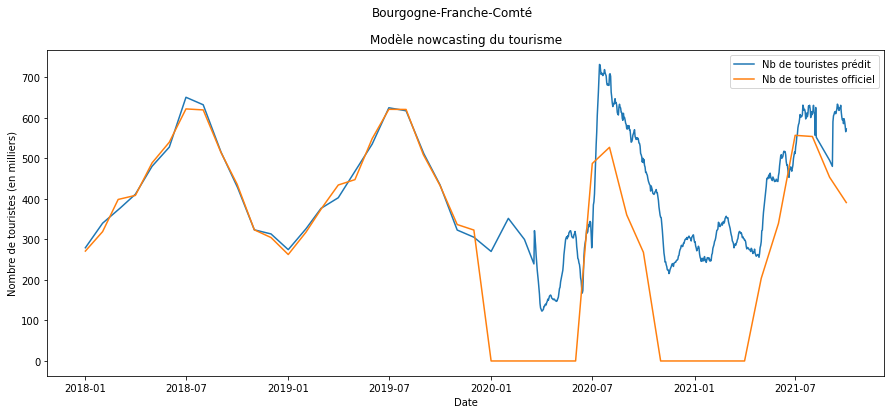

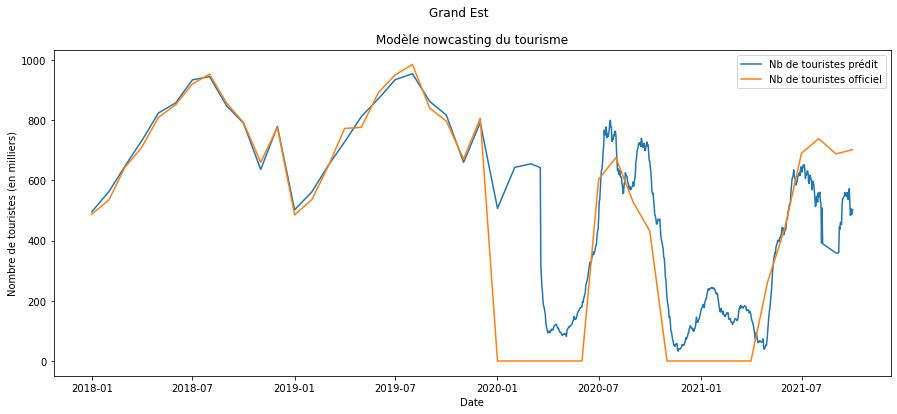

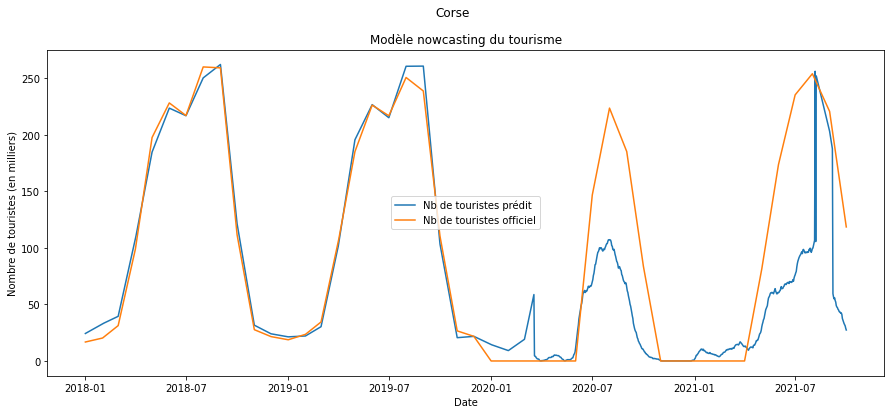

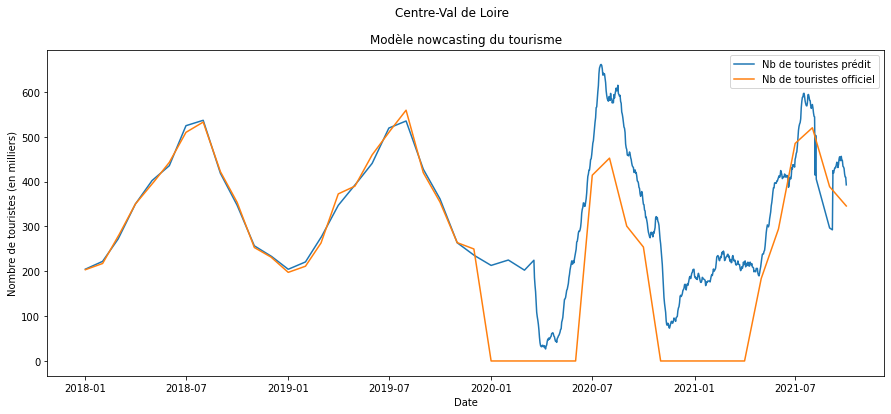

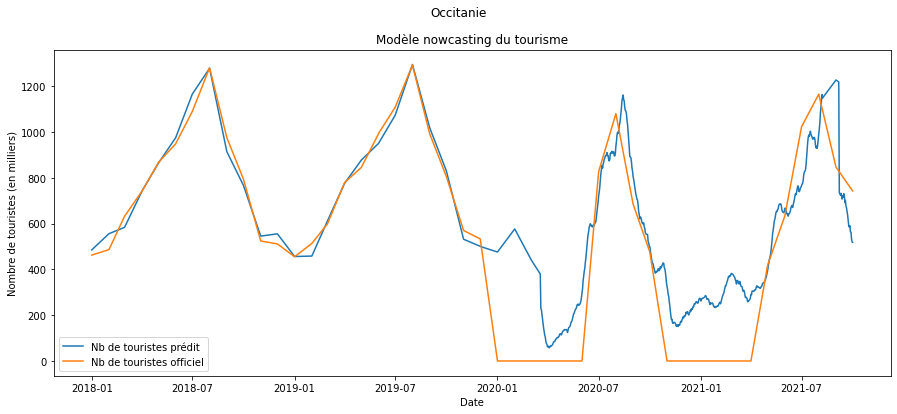

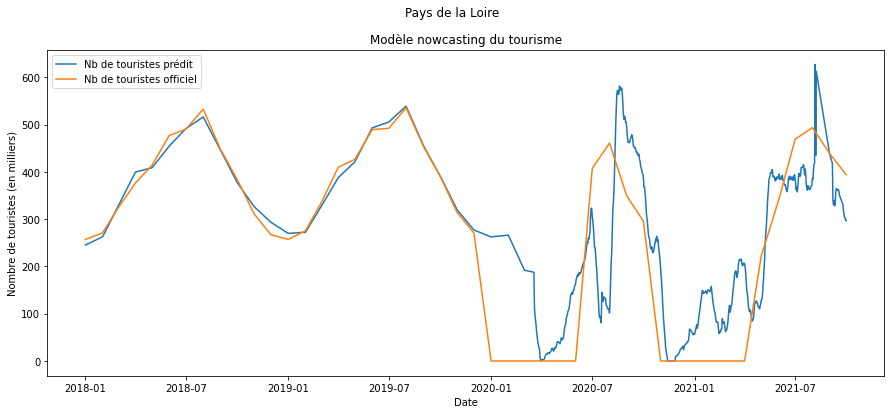

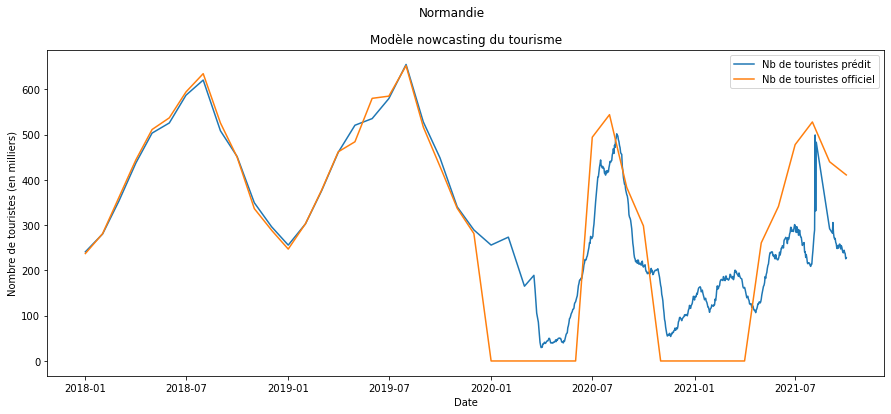

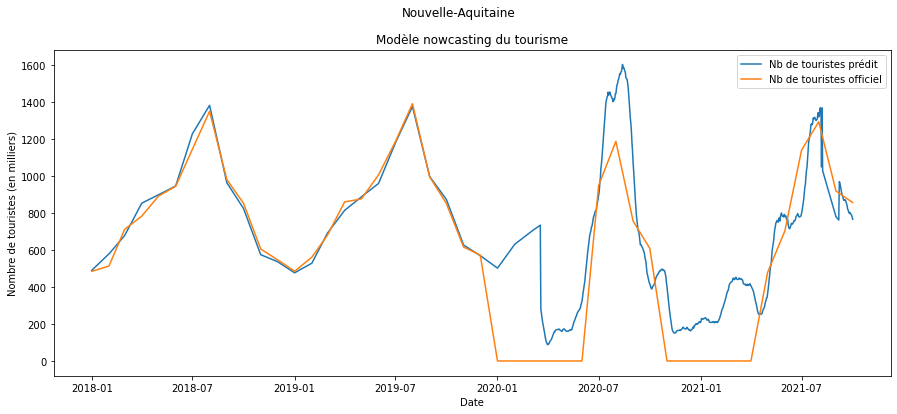

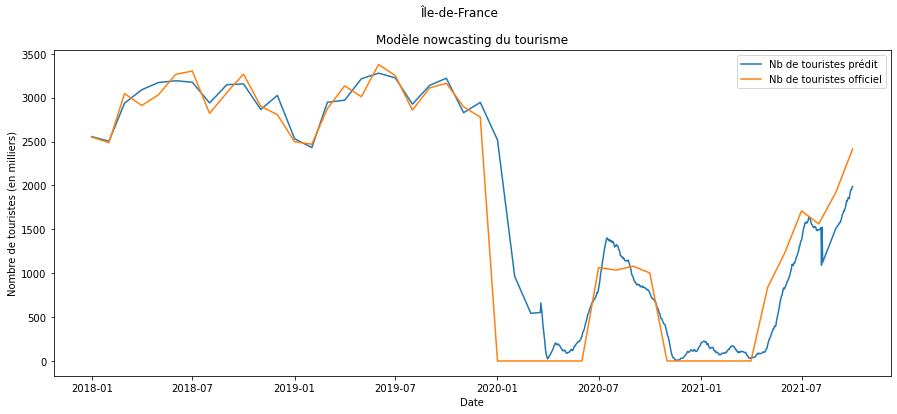

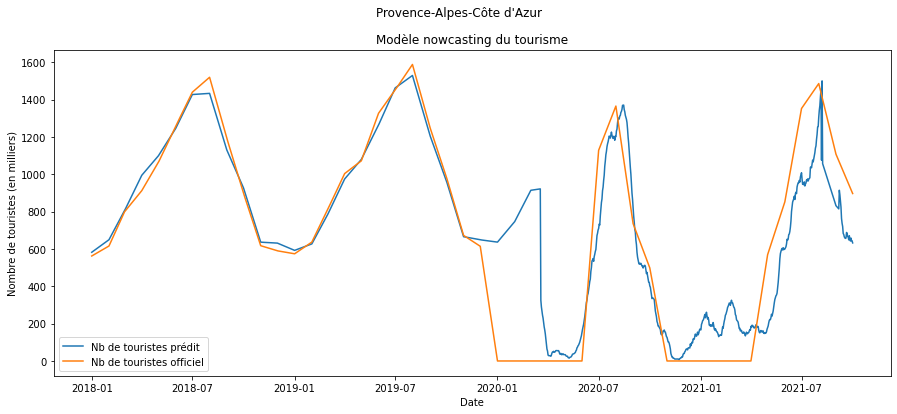

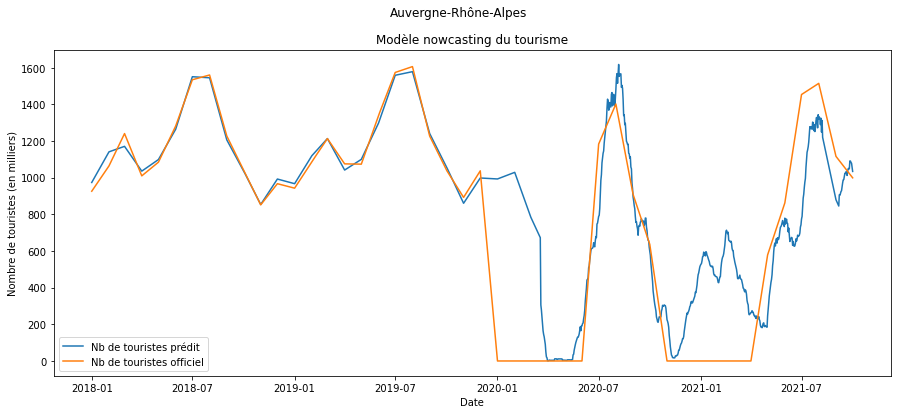

In [24]:
for region in prevision_touristes.columns.drop(['date', 'France métropolitaine']):

    x = prevision_touristes["date"]

    y1 = prevision_touristes[region]

    nb_touristes_off = reduc_base_region(region).reset_index()
    df_days = pd.DataFrame(pd.date_range("2018-01-01", "2021-10-01")).rename(columns={0:"date"})
    nb_touristes_off_jour = df_days.merge(nb_touristes_off, how="left").set_index('date')
    nb_touristes_off_jour['value_in_thousands'] = nb_touristes_off_jour['value_in_thousands'].interpolate(method='linear')
    y2 = nb_touristes_off_jour['value_in_thousands']

    plt.figure(1, figsize=(15, 6))
    plt.plot(x, y1, label="Nb de touristes prédit")
    plt.plot(x, y2, label="Nb de touristes officiel")
    plt.title('Modèle nowcasting du tourisme')
    plt.suptitle(region)
    plt.xlabel('Date')
    plt.ylabel("Nombre de touristes (en milliers)")
    plt.legend()
    plt.show()